In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from ast import literal_eval
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler

# Load the dataset
hbo = pd.read_csv("hbo_titles.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3030 non-null   object 
 1   title                 3030 non-null   object 
 2   type                  3030 non-null   object 
 3   description           3021 non-null   object 
 4   release_year          3030 non-null   int64  
 5   age_certification     1911 non-null   object 
 6   runtime               3030 non-null   int64  
 7   genres                3030 non-null   object 
 8   production_countries  3030 non-null   object 
 9   seasons               622 non-null    float64
 10  imdb_id               2768 non-null   object 
 11  imdb_score            2731 non-null   float64
 12  imdb_votes            2714 non-null   float64
 13  tmdb_popularity       3013 non-null   float64
 14  tmdb_score            2858 non-null   float64
dtypes: float64(5), int64(

In [ ]:
# look at the data
hbo.info()
print(hbo.head())

In [2]:
# Check NAs
hbo.isna().sum()

id                         0
title                      0
type                       0
description                9
release_year               0
age_certification       1119
runtime                    0
genres                     0
production_countries       0
seasons                 2408
imdb_id                  262
imdb_score               299
imdb_votes               316
tmdb_popularity           17
tmdb_score               172
dtype: int64

In [3]:
# Delete rows with NA in imdb_score column
hbo=hbo.dropna(subset=['imdb_score'])

In [4]:
# Check column types
type(hbo['genres'])
type(hbo['production_countries'])

pandas.core.series.Series

In [5]:
# Change genres and countries columns to lists

hbo['genres'] = hbo['genres'].apply(literal_eval)
hbo['production_countries'] = hbo['production_countries'].apply(literal_eval)

In [6]:
type(hbo.loc[0, 'genres'])

list

In [7]:
# Convert to binary format
df = []  
columns_to_encode = ['genres', 'production_countries'] 

# One-hot encoding
for col in columns_to_encode:
    encoded = hbo[col].explode().str.get_dummies().groupby(level=0).max()
    encoded = encoded.add_prefix(f'{col}_') 
    df.append(encoded)

# Merge one-hot columns with the original DataFrame
hbo_final = pd.concat([hbo] + df, axis=1)

In [8]:
print(hbo_final.head())

         id                 title   type  \
0   tm77588            Casablanca  MOVIE   
1  tm155702      The Wizard of Oz  MOVIE   
2   tm83648          Citizen Kane  MOVIE   
3    tm3175  Meet Me in St. Louis  MOVIE   
4  ts225761         Tom and Jerry   SHOW   

                                         description  release_year  \
0  In Casablanca, Morocco in December 1941, a cyn...          1943   
1  Young Dorothy finds herself in a magical world...          1939   
2  Newspaper magnate, Charles Foster Kane is take...          1941   
3  In the year before the 1904 St. Louis World's ...          1945   
4  Tom and Jerry is an American animated franchis...          1940   

  age_certification  runtime                                   genres  \
0                PG      102                    [drama, romance, war]   
1                 G      102                        [fantasy, family]   
2                PG      119                                  [drama]   
3               NaN   

In [9]:
# Get all columns with genres and countries
genre_cols = [col for col in hbo_final.columns if col.startswith('genres_')]
country_cols = [col for col in hbo_final.columns if col.startswith('production_countries_')]

# Count the number of movies and shows in each column
film_genre_sums = hbo_final[hbo_final["type"] == "MOVIE"][genre_cols].sum().sort_values(ascending=False)
film_country_sums = hbo_final[hbo_final["type"] == "MOVIE"][country_cols].sum().sort_values(ascending=False)

show_genre_sums = hbo_final[hbo_final["type"] == "SHOW"][genre_cols].sum().sort_values(ascending=False)
show_country_sums = hbo_final[hbo_final["type"] == "SHOW"][country_cols].sum().sort_values(ascending=False)

C:\Users\Elizaveta\AppData\Local\Temp\ipykernel_27148\1230127405.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=film_genres, y=film_top_genres.values, palette="Blues_r")
C:\Users\Elizaveta\AppData\Local\Temp\ipykernel_27148\1230127405.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=show_genres, y=show_top_genres.values, palette="Purples_r")


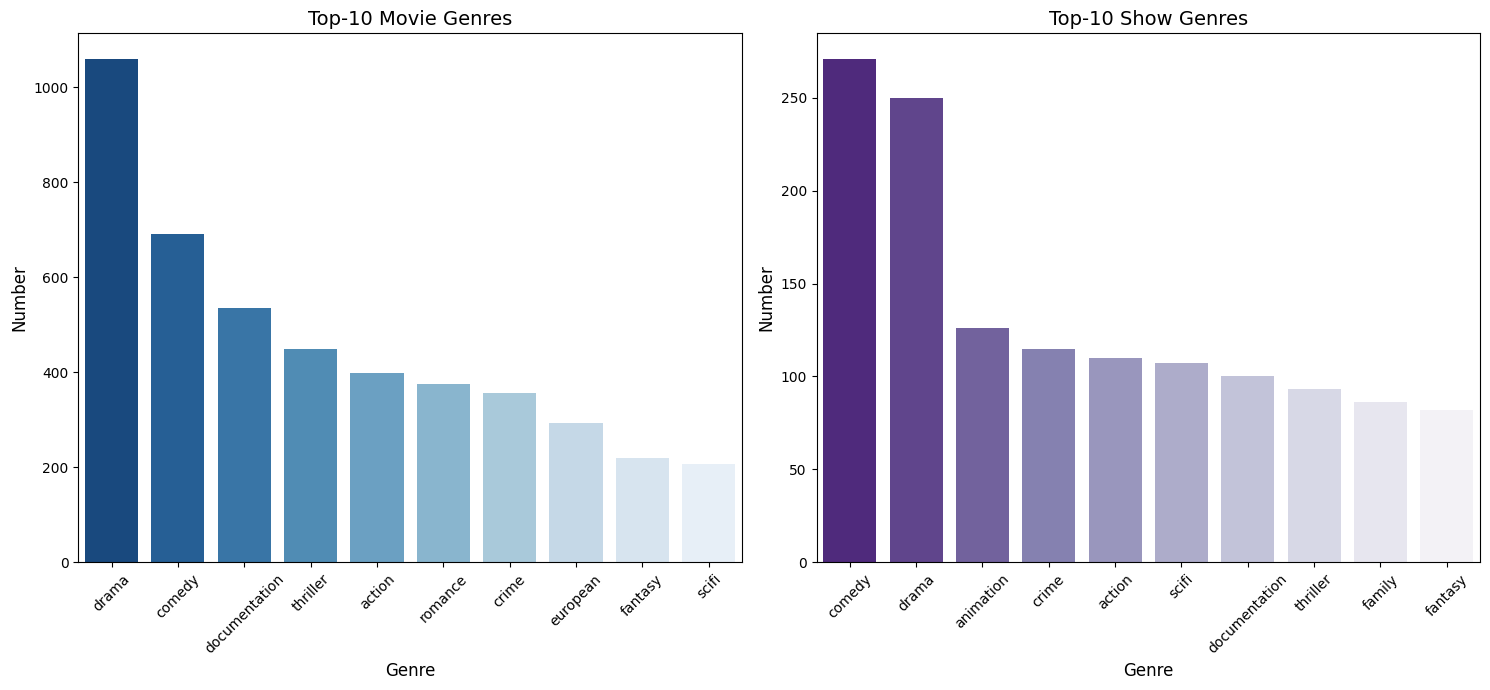

In [10]:
# Barplot: Top-10 genres of movies and shows
film_top_genres = film_genre_sums.head(10)
film_genres = [col.replace('genres_', '') for col in film_top_genres.index]

show_top_genres = show_genre_sums.head(10)
show_genres = [col.replace('genres_', '') for col in show_top_genres.index]

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.barplot(x=film_genres, y=film_top_genres.values, palette="Blues_r")
plt.title("Top-10 Movie Genres", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.xticks(rotation=45) 

plt.subplot(1, 2, 2)
sns.barplot(x=show_genres, y=show_top_genres.values, palette="Purples_r")
plt.title("Top-10 Show Genres", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()

# Drama and Comedy are the most popular genres for both movies and shows. Romance and European are in the top-10 for movies, but not for shows, while
# Animation and Family are in the top-10 for shows and not for movies

C:\Users\Elizaveta\AppData\Local\Temp\ipykernel_27148\3732054733.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=film_countries, y=film_top_countries.values, palette="flare")
C:\Users\Elizaveta\AppData\Local\Temp\ipykernel_27148\3732054733.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=show_countries, y=show_top_countries.values, palette="crest")


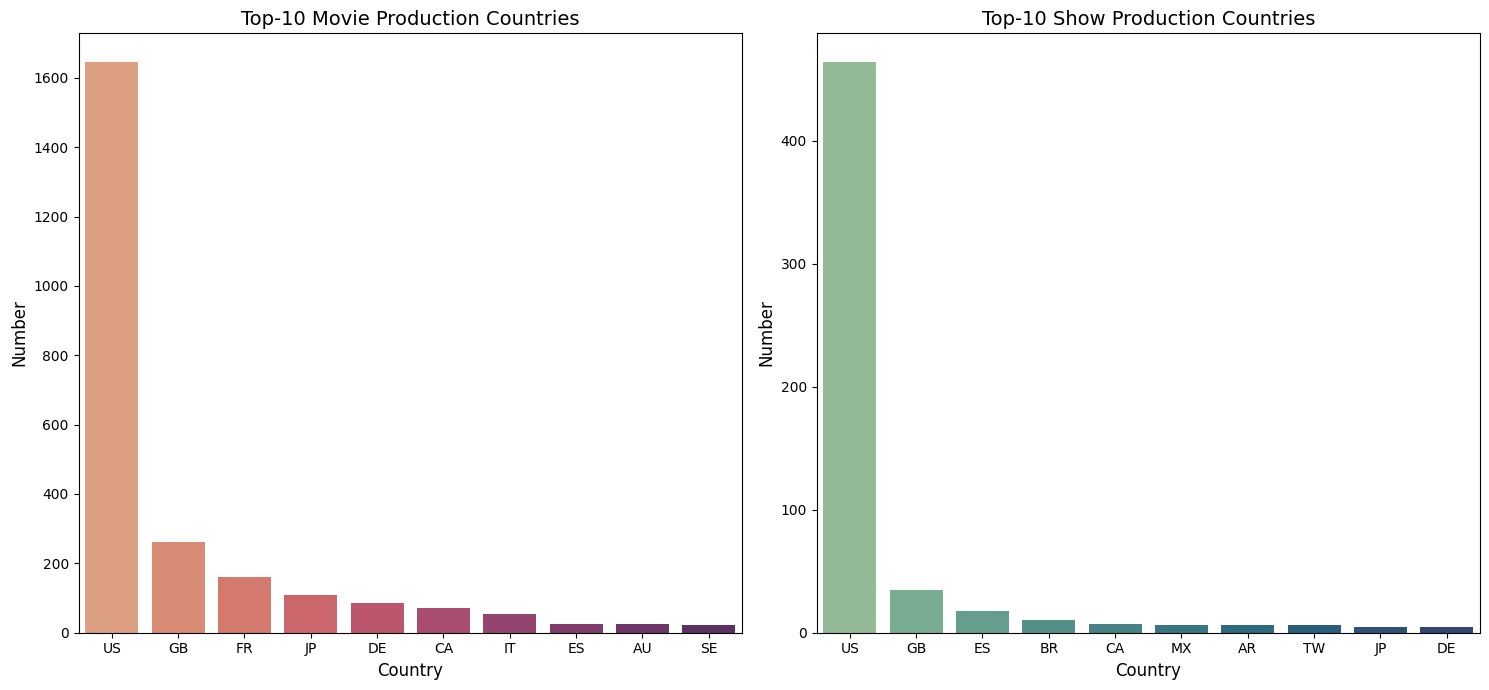

In [11]:
# Barplot: Top-10 production countries for movies and shows
film_top_countries = film_country_sums.head(10)
film_countries = [col.replace('production_countries_', '') for col in film_top_countries.index]

show_top_countries = show_country_sums.head(10)
show_countries = [col.replace('production_countries_', '') for col in show_top_countries.index]

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.barplot(x=film_countries, y=film_top_countries.values, palette="flare")
plt.title("Top-10 Movie Production Countries", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x=show_countries, y=show_top_countries.values, palette="crest")
plt.title("Top-10 Show Production Countries", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.tight_layout()
plt.show()

# US is the clear leader for both movies and shows production, followed next with a significant drop is Great Britain. 

In [12]:
# Analyse how our variables influence IMDB scores for movies and shows
# Create separate dataframes for movies and shows 

movies = hbo_final[hbo_final['type'] == 'MOVIE']
shows = hbo_final[hbo_final['type'] == 'SHOW']

In [13]:
# Choose predictors for movie scores (exclude irrelevant variables)
X_m = movies.drop(['id', 'title', 'type', 'description', 'genres', 'production_countries', 'age_certification', 'seasons', 'imdb_id', 'imdb_score', 
                   'imdb_votes', 'tmdb_popularity', 'tmdb_score'], axis=1) 
y_m = movies['imdb_score']  

In [14]:
# Check for multicollinearity
pd.set_option('display.max_rows', None)

vif_data = pd.DataFrame()
vif_data["feature"] = X_m.columns
vif_data["VIF"] = [variance_inflation_factor(X_m.values, i) for i in range(X_m.shape[1])]
print(vif_data)

# VIF (Variance Inflation Factor) results show how each variable depends on other variables in our model, the higher is VIF the higher is 
# multicollinearity. We have different scale variables like release_year and runtime, which differ in units of measurement (2020 vs 100 e.g.). 
# To solve the problem we need to use standardization.

D:\Miniconda\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
D:\Miniconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                    feature        VIF
0              release_year  33.788429
1                   runtime  19.304076
2             genres_action   2.180826
3          genres_animation   1.698433
4             genres_comedy   2.175541
5              genres_crime   1.599191
6      genres_documentation   2.946279
7              genres_drama   3.792295
8           genres_european   2.236831
9             genres_family   1.672857
10           genres_fantasy   1.569466
11           genres_history   1.279666
12            genres_horror   1.354710
13             genres_music   1.141365
14           genres_reality   1.006993
15           genres_romance   1.508065
16             genres_scifi   1.602105
17             genres_sport   1.157887
18          genres_thriller   2.079964
19               genres_war   1.279123
20           genres_western   1.081923
21  production_countries_AE   1.017583
22  production_countries_AF   1.019357
23  production_countries_AR   1.086243
24  production_countries_

In [15]:
# Standardization

numeric_cols = ['release_year', 'runtime']
X_standardized = X_m.copy()
scaler = StandardScaler()
X_standardized[numeric_cols] = scaler.fit_transform(X_standardized[numeric_cols])

In [16]:
# Check for multicollinearity again

vif_data = pd.DataFrame()
vif_data["feature"] = X_standardized.columns
vif_data["VIF"] = [variance_inflation_factor(X_standardized.values, i) for i in range(X_standardized.shape[1])]
print(vif_data)

# Now all variables show good VIF results, except for a few countries with inf or NaN results, which means there is only one or none mentions of these 
# countries

D:\Miniconda\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
D:\Miniconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                    feature       VIF
0              release_year  1.468131
1                   runtime  1.379494
2             genres_action  2.150309
3          genres_animation  1.738276
4             genres_comedy  1.919778
5              genres_crime  1.580733
6      genres_documentation  2.242554
7              genres_drama  2.854176
8           genres_european  2.224351
9             genres_family  1.693595
10           genres_fantasy  1.566536
11           genres_history  1.278156
12            genres_horror  1.335092
13             genres_music  1.134980
14           genres_reality  1.006510
15           genres_romance  1.540523
16             genres_scifi  1.574954
17             genres_sport  1.145115
18          genres_thriller  2.053835
19               genres_war  1.285186
20           genres_western  1.087230
21  production_countries_AE  1.018465
22  production_countries_AF  1.018732
23  production_countries_AR  1.088270
24  production_countries_AT  1.163617
25  producti

In [17]:
# Delete countries with only few or none mentions
X_standardized = X_standardized[['release_year', 'runtime', 'genres_action', 'genres_animation', 'genres_comedy', 'genres_crime', 'genres_documentation', 
                                 'genres_drama', 'genres_european', 'genres_family', 'genres_fantasy', 'genres_history', 'genres_horror', 'genres_music',
                                 'genres_reality', 'genres_romance', 'genres_scifi', 'genres_sport', 'genres_thriller', 'genres_war', 'genres_western', 
                                 'production_countries_US', 'production_countries_GB', 'production_countries_FR', 'production_countries_JP', 
                                 'production_countries_DE', 'production_countries_CA', 'production_countries_IT']]

In [18]:
# Add constant for intercept
X_standardized = sm.add_constant(X_standardized)

# OLS Regression
model_m = sm.OLS(y_m, X_standardized).fit()  
print(model_m.summary())

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     28.13
Date:                Wed, 13 Aug 2025   Prob (F-statistic):          5.22e-124
Time:                        18:13:10   Log-Likelihood:                -2633.0
No. Observations:                2153   AIC:                             5324.
Df Residuals:                    2124   BIC:                             5489.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [19]:
# Delete statistically insignificant and rare variables, leave possibly significant
X_standardized = X_standardized[['const', 'release_year', 'runtime', 'genres_action', 'genres_animation', 'genres_comedy', 'genres_documentation', 
                                 'genres_drama', 'genres_family', 'genres_fantasy', 'genres_history', 'genres_horror', 'genres_romance', 'genres_sport',
                                 'production_countries_US', 'production_countries_FR', 'production_countries_CA']]

In [20]:
# New model
model_m1 = sm.OLS(y_m, X_standardized).fit() 
print(model_m1.summary())

# R² = 0.267: Model explains 26.7% of IMDB score variation. Compared to previous model it dropped from 0.271, which is expected since many variables were
# deleted, however it is only a slight drop, which means deleted variables were not significantly contributing to explaining variation in the dependent
# variable. Adjusted R² remained the same (0.261), which proves that deleting variables was a right decision since the model became more compact without
# losing in quality. The F-statistic is higher (48.42 vs 28.13) and is highly significant (p ≈ 0). This suggests that second model is more efficient and
# has stronger collective significance of the included predictors.
# As for predictors: newer movies receive lower scores, longer movies score higher, animation, documentation, drama and historical movies score higher,
# while action, comedy, family, horror, romance and sport movies score lower. Fantasy movies became an insignificant predictor (p-value>0.05).
# Documentaries tend to get the highest boost to scores among all genres (0.71), while horrors damage scores the most (-0.41).
# As for production countries, USA and Canada both have statistically significant negative effect on scores, while France has a positive effect.
# Overall, this model does not have a very high R², so there is a need to add other predictors to the model.

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     48.52
Date:                Wed, 13 Aug 2025   Prob (F-statistic):          5.04e-131
Time:                        18:13:10   Log-Likelihood:                -2638.9
No. Observations:                2153   AIC:                             5312.
Df Residuals:                    2136   BIC:                             5408.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [21]:
# Testing model for homoscedasticity (Breusch-Pagan test)

bp_test_m = het_breuschpagan(model_m1.resid, model_m1.model.exog)
print(f"P-value: {bp_test_m[1]:.4f}")  
# P-value: 0.0000 — there is heteroscedasticity, which means dispersion of residuals is non-constant. Way to fix - use Robust Standard Errors 

P-value: 0.0000


In [22]:
# OLS with robust standard errors (HC3)
model_m_robust = sm.OLS(y_m, X_standardized).fit(cov_type='HC3')
print(model_m_robust.summary())

# After correction family genre is no longer significant.

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     46.92
Date:                Wed, 13 Aug 2025   Prob (F-statistic):          5.27e-127
Time:                        18:13:10   Log-Likelihood:                -2638.9
No. Observations:                2153   AIC:                             5312.
Df Residuals:                    2136   BIC:                             5408.
Df Model:                          16                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [23]:
# Shows analysis
# Choosing predictors
X_s = shows.drop(['id', 'title', 'type', 'description', 'genres', 'production_countries', 'age_certification', 'imdb_id', 'imdb_score', 'imdb_votes', 
                  'tmdb_popularity', 'tmdb_score'], axis=1)
y_s = shows['imdb_score']

In [24]:
# Standardization

numeric_cols = ['release_year', 'runtime', 'seasons']
X_stand = X_s.copy()
scaler = StandardScaler()
X_stand[numeric_cols] = scaler.fit_transform(X_stand[numeric_cols])

In [25]:
# Check for multicollinearity
pd.set_option('display.max_rows', None)

vif_data_s = pd.DataFrame()
vif_data_s["feature"] = X_stand.columns
vif_data_s["VIF"] = [variance_inflation_factor(X_stand.values, i) for i in range(X_stand.shape[1])]
print(vif_data_s)

# Variables show good VIF results, except for some countries with NaN results

D:\Miniconda\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                    feature       VIF
0              release_year  1.704843
1                   runtime  2.377546
2                   seasons  1.551817
3             genres_action  2.224601
4          genres_animation  3.073719
5             genres_comedy  3.286795
6              genres_crime  1.827522
7      genres_documentation  1.912070
8              genres_drama  3.499429
9           genres_european  1.895490
10            genres_family  2.031379
11           genres_fantasy  2.034024
12           genres_history  1.394408
13            genres_horror  1.411873
14             genres_music  1.144281
15           genres_reality  1.342869
16           genres_romance  1.353127
17             genres_scifi  2.492231
18             genres_sport  1.105386
19          genres_thriller  1.784238
20               genres_war  1.358918
21           genres_western  1.054488
22  production_countries_AE       NaN
23  production_countries_AF       NaN
24  production_countries_AR  1.343374
25  producti

In [26]:
# Delete countries with few or none mentions
X_stand = X_stand[['release_year', 'runtime', 'seasons', 'genres_action', 'genres_animation', 'genres_comedy', 'genres_crime', 'genres_documentation', 
                   'genres_drama', 'genres_european', 'genres_family', 'genres_fantasy', 'genres_history', 'genres_horror', 'genres_music', 
                   'genres_reality', 'genres_romance', 'genres_scifi', 'genres_sport', 'genres_thriller', 'genres_war', 'genres_western',
                   'production_countries_US', 'production_countries_GB', 'production_countries_ES']]

In [27]:
# Add constant for intercept
X_stand = sm.add_constant(X_stand)

# OLS Regression
model_s = sm.OLS(y_s, X_stand).fit()
print(model_s.summary())

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     3.831
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           2.72e-09
Time:                        18:13:14   Log-Likelihood:                -814.52
No. Observations:                 578   AIC:                             1681.
Df Residuals:                     552   BIC:                             1794.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [28]:
# Delete statistically insignificant variables, leave possibly significant
X_stand = X_stand[['const', 'release_year', 'runtime', 'seasons', 'genres_animation', 'genres_drama', 'genres_european', 'genres_family', 
                   'genres_fantasy', 'genres_history', 'production_countries_US']]

In [29]:
# New model
model_s1 = sm.OLS(y_s, X_stand).fit() 
print(model_s1.summary())

# R² decreased from 0.148 to 0.130, however adjusted R² on the contrary increased from 0.109 to 0.115, which means despite explaining less variance it is
# more efficient, so deleted variables were indeed not significant. The F-statistic is slightly higher (3.8 vs 8.5) and is significant (p ≈ 0). This 
# confirms that second model is more efficient.
# As for predictors, it is apparent that newer shows receive lower scores just like movies, longer runtime positively affects ratings, shows with more
# seasons get higher scores. Drama and history genres in shows score higher similarly to movies. Family shows on the contrary have negative effect on the
# score. Fantasy genre became insignificant in the second model. Animation and documentaries scored high for movies, however for shows they are not
# statistically significant. The highest positive effect in the model is history genre (0.48) (as opposed to documentaries in movies), and family genre
# is the most negative (-0.44) (as opposed to horror in movies). Production countries in shows were all statistically insignificant.
# This model still has a low R² overall, so there is a need to look at other predictors as well.

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     8.482
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           6.01e-13
Time:                        18:13:14   Log-Likelihood:                -820.47
No. Observations:                 578   AIC:                             1663.
Df Residuals:                     567   BIC:                             1711.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [30]:
# Testing model for homoscedasticity (Breusch-Pagan test)

bp_test_s = het_breuschpagan(model_s1.resid, model_s1.model.exog)
print(f"P-value: {bp_test_s[1]:.4f}")  
# P-value: 0.12 - the residuals have constant variance (homoscedasticity)

P-value: 0.1226


In [31]:
# Merge original dataset with data about actors and directors to see if it improves the quality of our models
# Load the dataset
hbo_credit = pd.read_csv("hbo_credits.csv")

# look at the data
hbo_credit.info()
print(hbo_credit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64879 entries, 0 to 64878
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   person_id  64879 non-null  int64 
 1   id         64879 non-null  object
 2   name       64879 non-null  object
 3   character  60648 non-null  object
 4   role       64879 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.5+ MB
   person_id       id             name                character   role
0      14701  tm77588  Humphrey Bogart              Rick Blaine  ACTOR
1      14702  tm77588   Ingrid Bergman                Ilsa Lund  ACTOR
2      14703  tm77588     Paul Henreid            Victor Laszlo  ACTOR
3      14704  tm77588     Claude Rains    Captain Louis Renault  ACTOR
4      14705  tm77588     Conrad Veidt  Major Heinrich Strasser  ACTOR


In [32]:
# Merge by id
hbo_merged = pd.merge(
    hbo_final,         
    hbo_credit,       
    on='id',
    how='left'
)

print(hbo_merged[['id', 'title', 'name', 'role']].head())

        id       title             name   role
0  tm77588  Casablanca  Humphrey Bogart  ACTOR
1  tm77588  Casablanca   Ingrid Bergman  ACTOR
2  tm77588  Casablanca     Paul Henreid  ACTOR
3  tm77588  Casablanca     Claude Rains  ACTOR
4  tm77588  Casablanca     Conrad Veidt  ACTOR


In [33]:
# Top-50 actors by average movie and show score
actor_ratings = hbo_merged[hbo_merged["role"] == "ACTOR"].groupby('name')['imdb_score'].agg(['mean', 'count']).rename(columns={'mean': 'mean_score', 'count': 'number'})
actor_ratings[actor_ratings['number'] >= 5].sort_values('mean_score', ascending=False).head(50)

,mean_score,number
name,,
Bret McKenzie,8.480000,5
Takeshi Katō,8.280000,5
Peter Jackson,8.266667,6
Katie Jackson,8.266667,6
Jed Brophy,8.214286,7
Isao Kimura,8.160000,5
Atsushi Watanabe,8.140000,5
Kichijirô Ueda,8.133333,6
Daisuke Katō,8.128571,7


In [34]:
# Top-30 directors by average movie and show score
director_ratings = hbo_merged[hbo_merged["role"] == "DIRECTOR"].groupby('name')['imdb_score'].agg(['mean', 'count']).rename(columns={'mean': 'mean_score', 'count': 'number'})
director_ratings[director_ratings['number'] >= 5].sort_values('mean_score', ascending=False).head(30)

,mean_score,number
name,,
Peter Jackson,8.257143,7
Akira Kurosawa,8.166667,9
Christopher Nolan,8.083333,6
Hayao Miyazaki,8.011111,9
Martin Scorsese,8.000000,7
Satyajit Ray,7.923077,13
Ingmar Bergman,7.920000,10
Yasujirō Ozu,7.869231,13
Charlie Chaplin,7.838462,13


In [35]:
# Ranking actors using Bayesian average to account for average IMDB score as well as number of movies/shows and reduce the impact of actors that have
# a high score but only 1-2 projects. Bayesian average gives more weight to the prior average, preventing a few outliers from disproportionately 
# influencing the overall score.

# Average score across dataset and minimal number of films/shows needed for actor to outweight global average
m = hbo_final["imdb_score"].mean()
C = 5 

# Weighted score, which punishes actors with few projects
actor_ratings["weighted_rating"] = (C * m + actor_ratings['number'] * actor_ratings['mean_score']) / (C + actor_ratings['number']) - (1 / actor_ratings['number'])

# Appointing tiers 
actor_bins = [0, 6.0, 6.5, 7.0, 10]
actor_labels = ['Low-tier', 'Third-tier', 'Second-tier', 'Top-tier']
actor_ranks = pd.cut(actor_ratings["weighted_rating"], bins=actor_bins, labels=actor_labels)

# Merge with dataset
hbo_merged["actor_rank"] = None
actor_mask = hbo_merged["role"] == "ACTOR"
hbo_merged.loc[actor_mask, "actor_rank"] = hbo_merged.loc[actor_mask, "name"].map(actor_ranks)

In [36]:
print(actor_ratings.describe())

         mean_score        number  weighted_rating
count  42971.000000  42971.000000     42971.000000
mean       6.897242      1.386772         6.048155
std        0.944199      1.107907         0.305405
min        1.500000      1.000000         5.031033
25%        6.350000      1.000000         5.864366
50%        7.000000      1.000000         5.997699
75%        7.600000      1.000000         6.131033
max        9.400000     27.000000         7.583228


In [37]:
actor_ratings.head(10)

,mean_score,number,weighted_rating
name,,,
Amanda Phillips,8.000000,1,6.114366
'Auntie' Mackay,7.100000,1,5.964366
'Little Man' Machan,5.166667,3,5.939941
'Weird Al' Yankovic,6.700000,1,5.897699
50 Cent,5.766667,3,6.164941
A$AP Rocky,6.700000,1,5.897699
A. Ali Flores,5.500000,1,5.697699
A. Begak,8.000000,1,6.114366
A. Boldyrev,8.400000,1,6.181033


In [38]:
# Ranking directors using the same method, m and C are the same

# Weighted score, which punishes directors with few works
director_ratings["weighted_rating"] = (C * m + director_ratings['number'] * director_ratings['mean_score']) / (C + director_ratings['number']) - (1 / director_ratings['number'])

# Appointing tiers 
director_bins = [0, 6.0, 6.9, 10]
director_labels = ['Low-tier', 'Second-tier', 'Top-tier']
director_ranks = pd.cut(director_ratings["weighted_rating"], bins=director_bins, labels=director_labels)

# Merge with dataset
hbo_merged["director_rank"] = None
director_mask = hbo_merged["role"] == "DIRECTOR"
hbo_merged.loc[director_mask, "director_rank"] = hbo_merged.loc[director_mask, "name"].map(director_ranks)

In [39]:
print(director_ratings.describe())

        mean_score       number  weighted_rating
count  1598.000000  1598.000000      1598.000000
mean      6.725487     1.526909         6.056280
std       0.939382     1.340180         0.363837
min       2.800000     1.000000         5.247699
25%       6.200000     1.000000         5.831033
50%       6.855000     1.000000         5.964366
75%       7.400000     1.000000         6.145996
max       9.300000    13.000000         7.616474


In [40]:
director_ratings.head(10)

,mean_score,number,weighted_rating
name,,,
Aaron Cohen,7.4,1,6.014366
Aaron Horvath,6.7,1,5.897699
Aaron Katz,5.4,1,5.681033
Aaron Kaufman,4.5,1,5.531033
Aaron Lubarsky,6.8,1,5.914366
Aaron Seltzer,2.8,1,5.247699
Abbas Kiarostami,7.7,1,6.064366
Abdallah Omeish,7.8,1,6.081033
Abe Levitow,7.7,1,6.064366


In [41]:
# Create separate dataframes for movies and shows 
movies_new = hbo_final[hbo_final['type'] == 'MOVIE']
shows_new = hbo_final[hbo_final['type'] == 'SHOW']

In [42]:
# Since there are many actors for each movie, we need to aggregate at the movie level. Create features for the number of actors in each movie, the 
# distribution of actor tiers, and an indicator for the presence of any top-tier actors

actor_agg = hbo_merged.groupby('id').agg(
    total_actors=('actor_rank', 'count'),
    act_top_tier=('actor_rank', lambda x: (x == 'Top-tier').sum()),
    act_second_tier=('actor_rank', lambda x: (x == 'Second-tier').sum()),
    act_third_tier=('actor_rank', lambda x: (x == 'Third-tier').sum()),
    act_low_tier=('actor_rank', lambda x: (x == 'Low-tier').sum()),
    has_top_tier_act=('actor_rank', lambda x: (x == 'Top-tier').any().astype(int))
)

In [43]:
# Turn into percentages
actor_agg['act_top_tier'] = actor_agg['act_top_tier'] / actor_agg['total_actors']
actor_agg['act_second_tier'] = actor_agg['act_second_tier'] / actor_agg['total_actors']
actor_agg['act_third_tier'] = actor_agg['act_third_tier'] / actor_agg['total_actors']
actor_agg['act_low_tier'] = actor_agg['act_low_tier'] / actor_agg['total_actors']

In [44]:
# Merge with the movie data
movie_model = pd.merge(movies_new[['id', 'imdb_score', 'release_year', 'runtime', 'genres_action', 'genres_animation', 'genres_comedy', 
                                   'genres_documentation', 'genres_drama', 'genres_family', 'genres_fantasy', 'genres_history', 'genres_horror', 
                                   'genres_romance', 'genres_sport', 'production_countries_US', 'production_countries_FR', 'production_countries_CA']],                        
                       actor_agg, on='id')
movie_model.head(10)

,id,imdb_score,release_year,runtime,genres_action,genres_animation,genres_comedy,genres_documentation,genres_drama,genres_family,...,genres_sport,production_countries_US,production_countries_FR,production_countries_CA,total_actors,act_top_tier,act_second_tier,act_third_tier,act_low_tier,has_top_tier_act
0,tm77588,8.5,1943,102,0,0,0,0,1,0,...,0,1,0,0,105,0.114286,0.447619,0.438095,0.0,1
1,tm155702,8.1,1939,102,0,0,0,0,0,1,...,0,1,0,0,23,0.043478,0.173913,0.782609,0.0,1
2,tm83648,8.3,1941,119,0,0,0,0,1,0,...,0,1,0,0,152,0.078947,0.322368,0.598684,0.0,1
3,tm3175,7.5,1945,113,0,0,1,0,1,1,...,0,1,0,0,44,0.022727,0.204545,0.772727,0.0,1
4,tm156463,8.2,1940,238,0,0,0,0,1,0,...,0,1,0,0,133,0.052632,0.330827,0.616541,0.0,1
5,tm82363,7.9,1946,114,0,0,0,0,0,0,...,0,1,0,0,46,0.152174,0.304348,0.543478,0.0,1
6,tm106979,7.9,1934,93,0,0,1,0,0,0,...,0,1,0,0,63,0.142857,0.301587,0.555556,0.0,1
7,tm14790,7.9,1945,111,0,0,0,0,1,0,...,0,1,0,0,58,0.068966,0.293103,0.637931,0.0,1
8,tm47834,8.3,1931,109,1,0,0,0,1,0,...,0,0,0,0,23,0.000000,0.478261,0.521739,0.0,0
9,tm5094,8.2,1948,126,0,0,0,0,1,0,...,0,1,0,0,32,0.093750,0.343750,0.562500,0.0,1


In [45]:
# Same calculations for directors
director_agg = hbo_merged.groupby('id').agg(
    total_directors=('director_rank', 'count'),
    dir_top_tier=('director_rank', lambda x: (x == 'Top-tier').sum()),
    dir_second_tier=('director_rank', lambda x: (x == 'Second-tier').sum()),
    dir_low_tier=('director_rank', lambda x: (x == 'Low-tier').sum()),
    has_top_tier_dir=('director_rank', lambda x: (x == 'Top-tier').any().astype(int))
)

In [46]:
# Turn into percentages
director_agg['dir_top_tier'] = director_agg['dir_top_tier'] / director_agg['total_directors']
director_agg['dir_second_tier'] = director_agg['dir_second_tier'] / director_agg['total_directors']
director_agg['dir_low_tier'] = director_agg['dir_low_tier'] / director_agg['total_directors']

In [47]:
# Merge with the movie data
movie_model = pd.merge(movie_model, director_agg, on='id')
movie_model.head(10)

,id,imdb_score,release_year,runtime,genres_action,genres_animation,genres_comedy,genres_documentation,genres_drama,genres_family,...,act_top_tier,act_second_tier,act_third_tier,act_low_tier,has_top_tier_act,total_directors,dir_top_tier,dir_second_tier,dir_low_tier,has_top_tier_dir
0,tm77588,8.5,1943,102,0,0,0,0,1,0,...,0.114286,0.447619,0.438095,0.0,1,1,1.000000,0.000000,0.0,1
1,tm155702,8.1,1939,102,0,0,0,0,0,1,...,0.043478,0.173913,0.782609,0.0,1,1,1.000000,0.000000,0.0,1
2,tm83648,8.3,1941,119,0,0,0,0,1,0,...,0.078947,0.322368,0.598684,0.0,1,1,1.000000,0.000000,0.0,1
3,tm3175,7.5,1945,113,0,0,1,0,1,1,...,0.022727,0.204545,0.772727,0.0,1,1,0.000000,1.000000,0.0,0
4,tm156463,8.2,1940,238,0,0,0,0,1,0,...,0.052632,0.330827,0.616541,0.0,1,3,0.666667,0.333333,0.0,1
5,tm82363,7.9,1946,114,0,0,0,0,0,0,...,0.152174,0.304348,0.543478,0.0,1,1,1.000000,0.000000,0.0,1
6,tm106979,7.9,1934,93,0,0,1,0,0,0,...,0.142857,0.301587,0.555556,0.0,1,1,0.000000,1.000000,0.0,0
7,tm14790,7.9,1945,111,0,0,0,0,1,0,...,0.068966,0.293103,0.637931,0.0,1,1,1.000000,0.000000,0.0,1
8,tm47834,8.3,1931,109,1,0,0,0,1,0,...,0.000000,0.478261,0.521739,0.0,0,1,0.000000,1.000000,0.0,0
9,tm5094,8.2,1948,126,0,0,0,0,1,0,...,0.093750,0.343750,0.562500,0.0,1,1,1.000000,0.000000,0.0,1


In [48]:
movie_model.isna().sum()

id                           0
imdb_score                   0
release_year                 0
runtime                      0
genres_action                0
genres_animation             0
genres_comedy                0
genres_documentation         0
genres_drama                 0
genres_family                0
genres_fantasy               0
genres_history               0
genres_horror                0
genres_romance               0
genres_sport                 0
production_countries_US      0
production_countries_FR      0
production_countries_CA      0
total_actors                 0
act_top_tier               119
act_second_tier            119
act_third_tier             119
act_low_tier               119
has_top_tier_act             0
total_directors              0
dir_top_tier                42
dir_second_tier             42
dir_low_tier                42
has_top_tier_dir             0
dtype: int64

In [49]:
movie_model=movie_model.dropna()

In [50]:
# New regression model for movies
X_m_n = movie_model.drop(['id', 'imdb_score'], axis=1) 
y_m_n = movie_model['imdb_score']

In [51]:
# Standardization
# It is not needed for percentages since already on a standard scale with bounds of 0 to 1, so they don’t suffer from the "scale disparity" problem
num_cols = ['release_year', 'runtime', 'total_actors', 'total_directors']
X_n_stand = X_m_n.copy()
scaler = StandardScaler()
X_n_stand[num_cols] = scaler.fit_transform(X_n_stand[num_cols])

In [52]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_n_stand.columns
vif_data["VIF"] = [variance_inflation_factor(X_n_stand.values, i) for i in range(X_n_stand.shape[1])]
print(vif_data)
# Since there are percentages, they sum to 100%, making one column predictable from the others, so drop one tier. Also drop has_top_tier_dir since it
# correlates highly with other director variables

                    feature        VIF
0              release_year   1.632972
1                   runtime   1.540195
2             genres_action   1.354247
3          genres_animation   1.594806
4             genres_comedy   1.359714
5      genres_documentation   2.172307
6              genres_drama   1.796304
7             genres_family   1.510841
8            genres_fantasy   1.329167
9            genres_history   1.070893
10            genres_horror   1.162360
11           genres_romance   1.221505
12             genres_sport   1.050892
13  production_countries_US   1.430095
14  production_countries_FR   1.176703
15  production_countries_CA   1.040703
16             total_actors   1.614637
17             act_top_tier        inf
18          act_second_tier        inf
19           act_third_tier        inf
20             act_low_tier        inf
21         has_top_tier_act   1.701120
22          total_directors   1.186049
23             dir_top_tier        inf
24          dir_second_ti

D:\Miniconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [53]:
X_n_stand=X_n_stand.drop(['act_third_tier', 'dir_second_tier', 'has_top_tier_dir'], axis=1)

In [54]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_n_stand.columns
vif_data["VIF"] = [variance_inflation_factor(X_n_stand.values, i) for i in range(X_n_stand.shape[1])]
print(vif_data)

                    feature       VIF
0              release_year  1.585437
1                   runtime  1.539494
2             genres_action  1.558312
3          genres_animation  1.669989
4             genres_comedy  1.876777
5      genres_documentation  2.180815
6              genres_drama  2.683219
7             genres_family  1.648095
8            genres_fantasy  1.486633
9            genres_history  1.147280
10            genres_horror  1.213823
11           genres_romance  1.497170
12             genres_sport  1.095318
13  production_countries_US  4.405362
14  production_countries_FR  1.185225
15  production_countries_CA  1.074893
16             total_actors  1.601108
17             act_top_tier  1.862419
18          act_second_tier  2.680603
19             act_low_tier  3.414801
20         has_top_tier_act  2.548074
21          total_directors  1.048738
22             dir_top_tier  1.739224
23             dir_low_tier  2.473205


In [55]:
# OLS Regression
X_n_stand = sm.add_constant(X_n_stand)
model_m_n = sm.OLS(y_m_n, X_n_stand).fit() 
print(model_m_n.summary())

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     101.1
Date:                Wed, 13 Aug 2025   Prob (F-statistic):          2.03e-322
Time:                        18:13:19   Log-Likelihood:                -1972.7
No. Observations:                2011   AIC:                             3995.
Df Residuals:                    1986   BIC:                             4136.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [56]:
# Testing model for homoscedasticity (Breusch-Pagan test)

bp_test_m_n = het_breuschpagan(model_m_n.resid, model_m_n.model.exog)
print(f"P-value: {bp_test_m_n[1]:.4f}")  
# P-value: 0.00 - use robust standard errors (HC3)

P-value: 0.0000


In [57]:
# OLS with robust standard errors (HC3)
model_mn_robust = sm.OLS(y_m_n, X_n_stand).fit(cov_type='HC3')
print(model_mn_robust.summary())

# Model explains significantly more variance with and without applying robust standard errors (R² 55% vs 26.7%) and fits the data much better, 
# adjusted R² is also pretty close to R² (54.4). F-statistic also improved (100.9 vs 46.92), so this model is definitely a better fit. 
# Coefficients decreased but remained significant for most core predictors: release_year dropped from -0.28 to -0.07, runtime from 0.18 to 0.09.
# Animation and fantasy became insignificant after applying robust errors. History and sport became insignificant when actor and director predictors 
# were added. Documentaries still have the highest positive genre effect, but the coefficient is lower (0.48 vs 0.71). The highest negative genre 
# effect changed from horrors to action films (-0.25), while horrors are now in second place (-0.2). As for production countries, the only significant
# country now is the USA that also has slightly higher negative effect (-0.2 vs -0.11). 
# Actor and director variables are strongly significant with and without robust errors, apart from the number of directors predictor that turned out to 
# be insignificant in both models. The higher number of actors slightly boosts score, top-tier actors and second-tier actors help increase ratings 
# (0.56 and 0.38 respectively) as well as top-tier directors (0.17). Having at least one top-tier actor also helps improve score (0.19). Low-tier actors
# and directors on the other hand hurt ratings (-0.8 and -0.4 respectively). Top-tier and low-tier actors are now the highest positive and negative 
# predictors in the model instead of genres.

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     100.9
Date:                Wed, 13 Aug 2025   Prob (F-statistic):          6.27e-322
Time:                        18:13:19   Log-Likelihood:                -1972.7
No. Observations:                2011   AIC:                             3995.
Df Residuals:                    1986   BIC:                             4136.
Df Model:                          24                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [58]:
# Now the same operations for shows
show_model = pd.merge(pd.merge(shows_new[['id', 'imdb_score', 'release_year', 'runtime', 'seasons', 'genres_animation', 'genres_drama', 
                                          'genres_european', 'genres_family', 'genres_fantasy', 'genres_history', 'production_countries_US']], 
                     actor_agg, on='id'), director_agg, on='id')
show_model.head(10)

,id,imdb_score,release_year,runtime,seasons,genres_animation,genres_drama,genres_european,genres_family,genres_fantasy,...,act_top_tier,act_second_tier,act_third_tier,act_low_tier,has_top_tier_act,total_directors,dir_top_tier,dir_second_tier,dir_low_tier,has_top_tier_dir
0,ts225761,7.7,1940,8,16.0,1,0,0,1,0,...,0.0,0.600000,0.400000,0.000000,0,7,0.0,1.0,0.0,0
1,ts80171,8.8,1929,7,17.0,1,0,0,1,0,...,0.0,1.000000,0.000000,0.000000,0,0,NaN,NaN,NaN,0
2,ts22230,7.9,1969,23,3.0,1,0,0,1,0,...,0.0,0.400000,0.600000,0.000000,0,3,0.0,1.0,0.0,0
3,ts15523,7.5,1960,29,6.0,1,0,0,1,0,...,0.0,0.600000,0.400000,0.000000,0,1,0.0,1.0,0.0,0
4,ts22243,8.1,1969,51,53.0,1,0,0,1,1,...,0.0,0.500000,0.500000,0.000000,0,0,NaN,NaN,NaN,0
5,ts20028,7.0,1962,30,3.0,1,0,0,1,0,...,0.0,0.375000,0.250000,0.375000,0,0,NaN,NaN,NaN,0
6,ts30782,7.2,1973,34,9.0,1,0,0,1,0,...,0.0,0.454545,0.272727,0.272727,0,0,NaN,NaN,NaN,0
7,ts21966,6.6,1961,11,4.0,1,0,0,1,0,...,0.0,0.444444,0.222222,0.333333,0,0,NaN,NaN,NaN,0
8,ts21149,7.0,1975,49,3.0,0,1,0,1,1,...,0.0,0.000000,0.500000,0.500000,0,0,NaN,NaN,NaN,0
9,ts21680,6.3,1979,15,6.0,1,0,0,1,0,...,0.0,1.000000,0.000000,0.000000,0,0,NaN,NaN,NaN,0


In [59]:
show_model.isna().sum()

id                           0
imdb_score                   0
release_year                 0
runtime                      0
seasons                      0
genres_animation             0
genres_drama                 0
genres_european              0
genres_family                0
genres_fantasy               0
genres_history               0
production_countries_US      0
total_actors                 0
act_top_tier                60
act_second_tier             60
act_third_tier              60
act_low_tier                60
has_top_tier_act             0
total_directors              0
dir_top_tier               514
dir_second_tier            514
dir_low_tier               514
has_top_tier_dir             0
dtype: int64

In [60]:
# Since the vast majority of shows (514 out of 578) do not have information about directors, it is sensible to remove them from the model
show_model=show_model.drop(['total_directors', 'dir_top_tier', 'dir_second_tier', 'dir_low_tier', 'has_top_tier_dir'], axis=1)

In [61]:
show_model.isna().sum()
show_model=show_model.dropna()

In [62]:
# New regression model for shows
X_s_n = show_model.drop(['id', 'imdb_score', 'act_third_tier'], axis=1) 
y_s_n = show_model['imdb_score']

In [63]:
# Standardization
num_cols_s = ['release_year', 'runtime', 'seasons', 'total_actors']
X_sn_stand = X_s_n.copy()
scaler = StandardScaler()
X_sn_stand[num_cols_s] = scaler.fit_transform(X_sn_stand[num_cols_s])

In [64]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_sn_stand.columns
vif_data["VIF"] = [variance_inflation_factor(X_sn_stand.values, i) for i in range(X_sn_stand.shape[1])]
print(vif_data)

                    feature       VIF
0              release_year  1.696851
1                   runtime  1.729599
2                   seasons  1.425014
3          genres_animation  2.605236
4              genres_drama  2.037053
5           genres_european  1.083808
6             genres_family  1.958103
7            genres_fantasy  1.440026
8            genres_history  1.200705
9   production_countries_US  3.637800
10             total_actors  1.480729
11             act_top_tier  2.400152
12          act_second_tier  2.617520
13             act_low_tier  1.499595
14         has_top_tier_act  3.030940


In [65]:
# OLS Regression
X_sn_stand = sm.add_constant(X_sn_stand)
model_s_n = sm.OLS(y_s_n, X_sn_stand).fit() 
print(model_s_n.summary())
# Delete highly insignificant variables

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     30.72
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           2.01e-61
Time:                        18:13:19   Log-Likelihood:                -599.41
No. Observations:                 518   AIC:                             1231.
Df Residuals:                     502   BIC:                             1299.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [66]:
X_sn_stand1 = X_sn_stand.drop(['has_top_tier_act', 'genres_animation', 'genres_drama'], axis=1)
model_s1_n = sm.OLS(y_s_n, X_sn_stand1).fit() 
print(model_s1_n.summary())

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     38.50
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           1.33e-63
Time:                        18:13:19   Log-Likelihood:                -599.84
No. Observations:                 518   AIC:                             1226.
Df Residuals:                     505   BIC:                             1281.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [67]:
# Testing the model for homoscedasticity (Breusch-Pagan test)

bp_test_s_n = het_breuschpagan(model_s1_n.resid, model_s1_n.model.exog)
print(f"P-value: {bp_test_s_n[1]:.4f}")  
# P-value: 0.02 - use robust standard errors

P-value: 0.0197


In [68]:
# OLS with robust standard errors (HC3)
model_sn_robust = sm.OLS(y_s_n, X_sn_stand1).fit(cov_type='HC3')
print(model_sn_robust.summary())

# R² of 0.478 indicates high explanatory power, adjusted R² is also close to R². Comparing to the model without actor data this model is much better 
# (0.130 vs 0.478). F-statistic also shows higher significance (8.48 vs 31.89).
# As for predictors, newer shows still receive lower scores, shows with longer runtime receive higher scores, but the number of seasons became 
# statistically insignificant in this model. Genres like drama and history also became statistically insignificant, while fantasy on the contrary
# became significant in its positive effect on scores (0.24). Family genre remained strongly significant, having a negative effect on ratings (-0.41).
# USA production became statistically significant, having a negative effect on scores (-0.21). Low-tier actors strongly reduce IMDB scores (-1.59),
# while top-tier actors highly increase scores (1.16), making them the most influential predictors. Second-tier actors and the number of actors have no
# significant impact (p > 0.05). 

# Comparing the final Movie and Show models, top-tier actors in shows have double the positive impact on scores, similarly low-tier actors hurt both, but
# for shows scores are less forgiving. Second-tier actors in movies have a significantly positive effect, while insignificant in shows. So for shows
# star power is more impactful on scores. Cast size matters more for movies, while insignificant for shows. Director quality is also important for 
# movies. Longer runtime helps both, and newer releases score lower in both. Movies benefit more from dramas and documentaries, while shows from fantasy 
# genre. Movies suffer from action, comedy, horror and romance, while shows from family genre. US production hurts both movie and show scores.

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     31.89
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           1.92e-54
Time:                        18:13:19   Log-Likelihood:                -599.84
No. Observations:                 518   AIC:                             1226.
Df Residuals:                     505   BIC:                             1281.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     